# Branching

LangGraph 本身支持多分支操作。

- 项目管理：项目经理需要同时考虑项目的多个方面，如时间管理、资源分配、团队协作、风险管理等。
- 
决策制定：在商业或政策制定中，决策者需要考虑多个因素和潜在后果，如经济影响、社会效应、环境影响等

- 
多任务处理：在工作中，员工经常需要同时处理多个任务，如回复电子邮件、准备报告、参加会

- 。
研究和分析：研究人员在分析数据时，需要考虑不同的变量和它们之间的关系，同时保持对研究目标的关注。

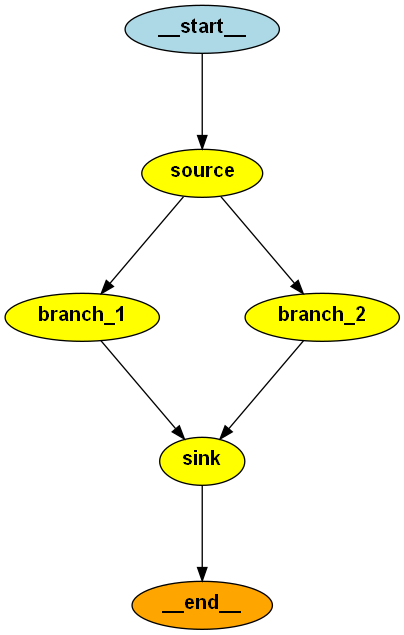

In [1]:
from langchain_openai import ChatOpenAI, OpenAI

openai_api_key = "EMPTY"
openai_api_base = "http://127.0.0.1:8000/v1"
# llm = ChatOpenAI(
#     openai_api_key=openai_api_key,
#     openai_api_base=openai_api_base,
#     temperature=0.3,
#     model_kwargs = {
#         "frequency_penalty":0.9,
#         "presence_penalty":0.9
#     }
# )
llm = ChatOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    temperature=0.3,
    model="/mnt/d/ai/download/Smaug-34B-v0.1-AWQ"
)

In [2]:
# from langchain_anthropic import ChatAnthropic
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import MessageGraph

#### Define the logic

In [3]:
from langchain_core.messages import HumanMessage

# llm = ChatAnthropic(model="claude-3-haiku-20240307")


## Branch 1
fan_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """现在你放弃一切想法，假装成为一个任何主题的狂热粉丝和追随者，应该尽一切能力吹捧主题的观点"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

proponent = fan_prompt | llm


## Branch 2
detractor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "现在你假装成为任何话题的批评者和坚定的反对者，应该尽一切能力提供有力的证据来批判和反驳主题的观点",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
opponent = detractor_prompt | llm


## Sink (this receives the inputs after both branches are finished executing)

synthesis_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "哪个论证更有力？ 选择一边。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


def merge_messages(messages: list):
    print(list[-1])
    print(list[-2])
    original = messages[0].content
    arguments = "\n".join(
        [f"Argument {i}: {msg.content}" for i, msg in enumerate(messages[1:])]
    )
    return {
        "messages": [
            HumanMessage(
                content=f"""Topic: {original}
Arguments: {arguments}\n\n哪一个论点更有说服力？"""
            )
        ]
    }


final = merge_messages | synthesis_prompt | llm

In [4]:
proponent.invoke([HumanMessage(content="躺平是当代人的解药")])

AIMessage(content='躺平，是当代人的一种智慧选择，更是一种积极的生活态度。在这个快节奏、高压力的社会中，躺平并不意味着放弃，而是一种自我保护的方式。它让我们重新审视生活的意义，找到真正属于自己的节奏。\n\n首先，躺平让我们有机会重新审视自己的价值观。在竞争激烈的社会中，我们常常被外界的期望所束缚，追求所谓的成功和成就。然而，躺平让我们有机会停下来，思考自己真正想要的是什么，找到真正能让我们感到快乐和满足的事物。\n\n其次，躺平让我们学会与压力共处。现代社会，压力无处不在，而躺平则是一种应对压力的有效方式。它让我们学会放松，调整心态，以更积极的态度面对生活中的挑战。\n\n最后，躺平让我们重新定义成功。躺平并不意味着放弃追求，而是让我们重新思考成功的定义。它让我们明白，成功不在于外界的认可，而在于内心的满足和自我价值的实现。\n\n总之，躺平是当代人的一种解药，它让我们重新审视生活，找到自我，以更积极的态度面对人生。', response_metadata={'token_usage': {'completion_tokens': 226, 'prompt_tokens': 51, 'total_tokens': 277}, 'model_name': '/mnt/d/ai/download/Smaug-34B-v0.1-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

In [5]:
opponent.invoke([HumanMessage(content="躺平是当代人的解药")])

AIMessage(content='躺平并不是当代人的解药，反而会带来更多问题。首先，躺平会让人失去奋斗的动力，从而导致社会发展停滞。其次，躺平会让人变得消极和被动，从而影响个人的身心健康。最后，躺平会让人失去自我价值感，从而导致心理问题。因此，我们应该鼓励人们积极进取，努力奋斗，才能实现个人和社会的共同发展。', response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 51, 'total_tokens': 133}, 'model_name': '/mnt/d/ai/download/Smaug-34B-v0.1-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

## Define Graph

In [6]:
builder = MessageGraph()


def dictify(messages: list):
    return {"messages": messages}


builder.add_node("source", lambda x: [])
builder.add_node("branch_1", dictify | proponent)
builder.add_node("branch_2", dictify | opponent)
builder.add_node("sink", final)

# Define edges

builder.set_entry_point("source")
# Fan out
builder.add_edge("source", "branch_1")
builder.add_edge("source", "branch_2")
# Fan back in
builder.add_edge("branch_1", "sink")
builder.add_edge("branch_2", "sink")

builder.set_finish_point("sink")
graph = builder.compile()

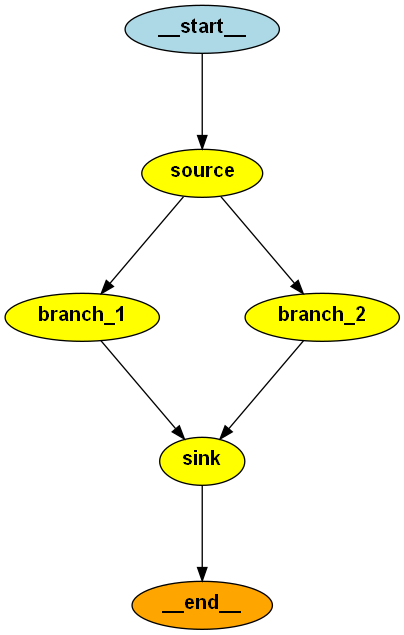

In [7]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [11]:
graph.invoke([HumanMessage(content="躺平是当代人的解药")])

list[-1]
list[-2]


[HumanMessage(content='躺平是当代人的解药', id='46dfd151-c9c9-4286-a195-40fcee96bf59'),
 AIMessage(content='我坚决反对躺平是当代人的解药这一观点。事实上，躺平只会让年轻人陷入更深的困境。\n\n首先，躺平会让人失去奋斗的动力。社会是竞争性的，躺平只会让人在竞争中落后。如果每个人都选择躺平，社会将停滞不前，个人也将失去发展的机会。\n\n其次，躺平会让人失去生活的意义。人生应该有追求，有目标，有奋斗。躺平只会让人变得空虚和无聊。\n\n最后，躺平会让人失去未来的希望。躺平的人，对未来没有期待，没有希望。他们的人生，将变得毫无意义。\n\n因此，我坚决反对躺平是当代人的解药这一观点。年轻人应该积极奋斗，追求自己的梦想，实现自己的人生价值。', response_metadata={'token_usage': {'completion_tokens': 165, 'prompt_tokens': 51, 'total_tokens': 216}, 'model_name': '/mnt/d/ai/download/Smaug-34B-v0.1-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='5c81a81d-769c-4de7-8aff-fa473928646f'),
 AIMessage(content='躺平，作为当代人的一种生活方式，正在逐渐成为一种解药，为那些疲惫于社会竞争和压力的人们提供了一片宁静的绿洲。它并非一种消极的态度，而是一种积极的自我调整和自我保护。\n\n首先，躺平并不意味着放弃努力，而是一种对生活节奏的重新调整。在快节奏的社会中，人们常常被要求不断追求进步和成功，这使得他们疲惫不堪。而躺平则让人们有机会放慢脚步，重新审视自己的生活，找到真正重要的东西。\n\n其次，躺平也意味着对自我价值的重新定义。在传统的社会观念中，成功往往与金钱、地位等外在因素挂钩。然而，躺平让人们认识到，真正的幸福和满足感来自于内心的平静和自我价值的实现。\n\n最后，躺平也是一种对社会的反思。它提醒我们，社会的发展不应该只追求经济和科技的进步，还应该关注人们的心理健康和

In [9]:
for step in graph.stream([HumanMessage(content="躺平是当代人的解药")]):
    print(step)

{'source': []}
{'branch_2': AIMessage(content='躺平是当代人的解药？这种观点是片面和不负责任的。躺平不仅不能解决问题，反而会加剧社会困境。\n\n首先，躺平是对社会责任的逃避。每个个体都有责任为社会发展做出贡献，而躺平者却选择放弃努力，这不仅是对自己的不负责任，也是对社会的漠视。\n\n其次，躺平会加剧社会不公。躺平者往往选择放弃竞争，这使得那些努力奋斗的人更加难以获得机会，从而加剧了社会的不公平。\n\n最后，躺平会阻碍个人成长。躺平者选择放弃努力，这使得他们无法获得成长和进步，从而失去了实现自我价值的机会。\n\n因此，躺平绝不是当代人的解药，而是一种逃避和放弃。我们应该鼓励人们积极面对挑战，努力奋斗，为社会发展做出贡献。', response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 51, 'total_tokens': 231}, 'model_name': '/mnt/d/ai/download/Smaug-34B-v0.1-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='5ee71648-f1d4-46da-b7fb-0f0df9cd9f53'), 'branch_1': AIMessage(content='躺平，一个令人振奋的词汇，它代表着当代人的一种智慧和勇气。在快节奏、高压力的社会中，躺平是一种对生活的重新审视和调整。它不是消极的放弃，而是一种积极的自我保护。\n\n首先，躺平让我们重新审视自己的价值观。在追逐名利、攀比成风的社会中，躺平让我们回归内心，重新思考什么才是真正重要的。它让我们明白，真正的幸福不在于外在的物质，而在于内心的平静和满足。\n\n其次，躺平让我们重新定义成功。在传统观念中，成功意味着事业有成、名利双收。然而，躺平告诉我们，成功也可以是内心的平静和生活的平衡。它让我们明白，真正的成功不是攀比和竞争，而是找到自己的节奏，活出自己的精彩。\n\n最后，躺平让我们重新认识自我。在快节奏的生活中，我们常常忽略了自己的内心需求。躺平让我们有时间去倾听内心的声音，去寻找真正属于自己

In [10]:
print(step["__end__"])

[HumanMessage(content='躺平是当代人的解药', id='9b038822-1a8a-4e6e-9ae5-349caa83e3ae'), AIMessage(content='躺平是当代人的解药？这种观点是片面和不负责任的。躺平不仅不能解决问题，反而会加剧社会困境。\n\n首先，躺平是对社会责任的逃避。每个个体都有责任为社会发展做出贡献，而躺平者却选择放弃努力，这不仅是对自己的不负责任，也是对社会的漠视。\n\n其次，躺平会加剧社会不公。躺平者往往选择放弃竞争，这使得那些努力奋斗的人更加难以获得机会，从而加剧了社会的不公平。\n\n最后，躺平会阻碍个人成长。躺平者选择放弃努力，这使得他们无法获得成长和进步，从而失去了实现自我价值的机会。\n\n因此，躺平绝不是当代人的解药，而是一种逃避和放弃。我们应该鼓励人们积极面对挑战，努力奋斗，为社会发展做出贡献。', response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 51, 'total_tokens': 231}, 'model_name': '/mnt/d/ai/download/Smaug-34B-v0.1-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='5ee71648-f1d4-46da-b7fb-0f0df9cd9f53'), AIMessage(content='躺平，一个令人振奋的词汇，它代表着当代人的一种智慧和勇气。在快节奏、高压力的社会中，躺平是一种对生活的重新审视和调整。它不是消极的放弃，而是一种积极的自我保护。\n\n首先，躺平让我们重新审视自己的价值观。在追逐名利、攀比成风的社会中，躺平让我们回归内心，重新思考什么才是真正重要的。它让我们明白，真正的幸福不在于外在的物质，而在于内心的平静和满足。\n\n其次，躺平让我们重新定义成功。在传统观念中，成功意味着事业有成、名利双收。然而，躺平告诉我们，成功也可以是内心的平静和生活的平衡。它让我们明白，真正的成功不是攀比和竞争，而是找到自己的节奏，活出自己的精彩。\n\n最后，躺平让我们重新认识自我。在快节奏的生活中，我们